In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
import torch

from pathlib import Path
from pprint import pprint
from tqdm import tqdm

from byol_pytorch import BYOL
from torch import nn
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler

# custom imports
from fairface_classification import data, utils

utils.set_random_seed(42)
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('colorblind')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/himars/Programming/Deep_Learning/fairface_classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_label = pd.read_csv('../data/fairface_label_train.csv')
resnet = resnet50(weights='IMAGENET1K_V1')
train_label.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [5]:
race_dict = data.read_json('../data/encodings/race_encoding.json')
gender_dict = data.read_json('../data/encodings/gender_encoding.json')
age_dict = data.read_json('../data/encodings/age_encoding.json')

encoders = {'race' : race_dict, 'age' : age_dict, 'gender' : gender_dict}
pprint(encoders)

{'age': {'0-2': 0,
         '10-19': 2,
         '20-29': 3,
         '3-9': 1,
         '30-39': 4,
         '40-49': 5,
         '50-59': 6,
         '60-69': 7,
         'more than 70': 8},
 'gender': {'Female': 1, 'Male': 0},
 'race': {'Black': 4,
          'East Asian': 3,
          'Indian': 2,
          'Latino_Hispanic': 1,
          'Middle Eastern': 6,
          'Southeast Asian': 5,
          'White': 0}}


In [6]:
train_samples = json.load(open('../train_test_val.json'))['train']
label_train_test = pd.read_csv('../data/fairface_label_train.csv')

class_weights = utils.calc_tasks_weight({'age' : age_dict, 
                                         'gender' : gender_dict, 
                                         'race' : race_dict})
train_labels = utils.calc_category_weights(train_samples, label_train_test, 
                                           {'age_dict' : age_dict, 
                                            'race_dict' : race_dict, 
                                            'gender_dict' : gender_dict})

       age: 1.50
      race: 1.17
    gender: 0.33


In [7]:
def group_class_weight(labels):
    """
    It is another way of calculation of image weight for oversampling technique.

    Args:
        labels: pd.DataFrame - dataframe with filenames and its labels.
    Returns:
        labels: pd.DataFrame - dataframe with calculated weights for every file and its labels.
    """

    labels['group'] = labels.apply(lambda x: f'{x["age"]}{x["gender"]}{x["race"]}', axis=1)
    group_vc = labels['group'].value_counts()
    group_counts = group_vc.to_frame().reset_index()
    labels = labels.merge(group_counts, on='group', how='left') 
    labels['group_weight'] = 1 / labels['count']
    return labels

train_labels = group_class_weight(train_labels)
train_labels = train_labels.drop(['age_weight', 'gender_weight', 'race_weight', 'total_weight'], 
                                 axis=1)
train_labels.head()

,file,age,gender,race,group,count,group_weight
0,train/1.jpg,6,0,3,603,272,0.003676
1,train/2.jpg,4,1,2,412,931,0.001074
2,train/4.jpg,3,1,2,312,1347,0.000742
3,train/5.jpg,3,1,2,312,1347,0.000742
4,train/7.jpg,5,0,6,506,961,0.001041


In [36]:
root_dir = Path('..')
images_dir = 'data/'

# Set the batch size for 64 samples
batch_size = 8

sampler = WeightedRandomSampler(weights=train_labels['group_weight'], num_samples=len(train_labels), replacement=True)

# Create a FairFaceDataset object for the training data.
fairface_train = data.FairFaceDataset('fairface_label_train.csv', 
                                        root_dir=root_dir, 
                                        mode='train',
                                        encoders=encoders,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Resize((224, 224))
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_train.train()
# Create a DataLoader object for the training data.
train_loader = DataLoader(fairface_train, batch_size=batch_size, num_workers=5, sampler=sampler)

# Create a FairFaceDataset object for the test data.
fairface_test = data.FairFaceDataset('fairface_label_train.csv', 
                                     root_dir=root_dir, 
                                     mode='test',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Resize((224, 224))
                                                                      ]))
# Set the FairFaceDataset object to train mode.
fairface_test.train()
# Create a DataLoader object for the test data.
test_loader = DataLoader(fairface_test, batch_size=batch_size, num_workers=5, shuffle=True)

# Create a FairFaceDataset object for the validation data.
fairface_val = data.FairFaceDataset('fairface_label_val.csv', 
                                     root_dir=root_dir, 
                                     mode='val',
                                     encoders=encoders,
                                     transform=transforms.Compose([transforms.ToTensor(),
                                                                   transforms.Resize((224, 224))
                                                                   ]))
# Set the FairFaceDataset object to train mode.
fairface_val.train()
# Create a DataLoader object for the validation data.
val_loader = DataLoader(fairface_val, batch_size=batch_size, shuffle=True, num_workers=5)

### Train the backbone of ResNet50 on FairFace with Contrastive Learning

In [37]:
from itertools import combinations, product

age_interest = range(2, 6)

def compute_cosine_similarity(a, b):
    """
    Compute the cosine similarity between two arrays.

    Args:
        a: np.ndarray - the first array.
        b: np.ndarray - the second array.

    Returns:
        float - the cosine similarity between the two arrays.
    """

    dot_product = torch.dot(a, b)
    norm_a = torch.linalg.norm(a)
    norm_b = torch.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def compute_features(model, image_batch):
    """
    Compute the features for the given batch of images.

    Args:
        model: torch.nn.Module - the model to compute the features for.
        batch: torch.Tensor - the batch of images.
    Returns:
        features: torch.Tensor - the features for the given batch of images.
    """
    with torch.no_grad():
        mod_model = nn.Sequential(*(list(model.children())[:-1])).cuda()
        features = mod_model(image_batch)
        features = features.view(features.size(0), -1)
    return features

def build_cosine_hist(similarities):
    """
    This function creates a histogram of cosine similarities, where the histogram is split into two parts: one for similarities between images of the same class, and one for similarities between images of different classes.

    Args:
        similarities (dict): a dictionary containing two keys: 'same_class' and 'diff_class', each containing a list of cosine similarities between pairs of images.

    Returns:
        fig (matplotlib.figure.Figure): the histogram figure.
        ax (matplotlib.axes._subplots.AxesSubplot): the histogram axes.

    """
    data = pd.DataFrame({'Cosine Similarity' : similarities['same_class'] + similarities['diff_class'], 
                         'Same' : [1 for i in range(len(similarities['same_class']))] + 
                                  [0 for i in range(len(similarities['diff_class']))]})
    
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(x='Cosine Similarity', hue='Same', data=data, bins=100)
    ax.set_xlabel('Cosine Similarity')
    plt.tight_layout()
    plt.show()
    
    return fig, ax

def compute_difference(loader, model, age_interest):
    """
    Compute the difference between age classes.

    Args:
        loader (DataLoader): the DataLoader object for the data.
        model (torch.nn.Module): the model used to extract features.
        age_interest (list): the ages of interest.

    Returns:
        age_features (dict): a dictionary of age classes and their features.

    """
    age_features = {i : [] for i in age_interest}

    pbar = tqdm(loader)
    for k, batch in enumerate(pbar):
        age_batch = [int(i) for i in batch['age']]
        image_batch = batch['image'].cuda()
        features = compute_features(model, image_batch)
        for i in range(features.size(0)):
            cur_age = age_batch[i]
            cur_feature = features[i]

            if cur_age in age_interest:
                age_features[cur_age].append(cur_feature)
                
        pbar.set_description(f'Computing features')
    
    similarities = {'same_class' : [], 'diff_class' : []}
    age_classes = list(age_features.keys())

    for k in tqdm(age_features.keys()):
        for i, j in combinations(age_features[k], 2):
            if not torch.equal(i, j):
                similarities['same_class'].append(compute_cosine_similarity(i, j))

    for cur_age, next_age in combinations(tqdm(age_classes), 2):

        for q, k in product(age_features[cur_age], age_features[next_age]):
            similarities['diff_class'].append(compute_cosine_similarity(q, k))

    for key, value in similarities.items():
        print(f'{key:>10}: {torch.mean(torch.Tensor(value)):.2f}')
    return age_features, similarities

Epoch = 0


epoch: 0, loss: 1.230719804763794:   0%|          | 15/8675 [00:13<2:12:07,  1.09it/s] 


Epoch 1/5, Loss: 0.0027


Computing features:   2%|▏         | 50/2169 [00:18<13:06,  2.70it/s]


same_class: 0.81
diff_class: 0.81


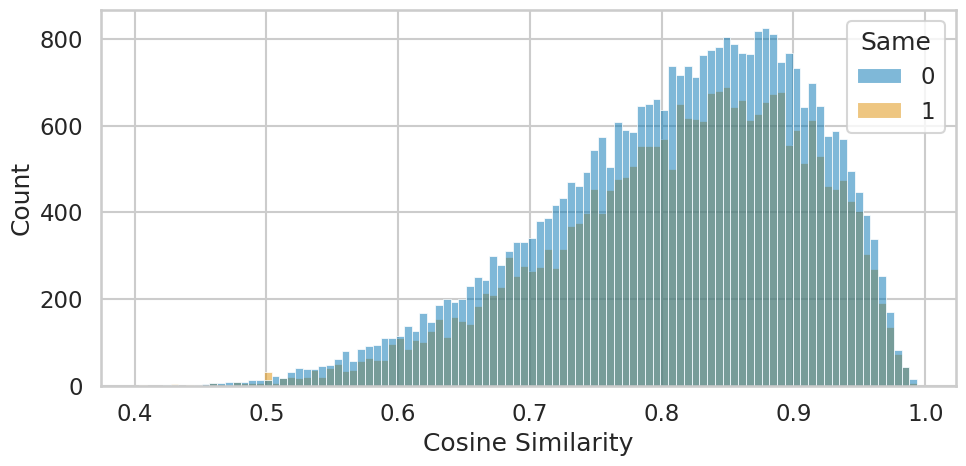

Epoch = 1


epoch: 1, loss: 0.8999321460723877:   0%|          | 15/8675 [00:35<5:42:03,  2.37s/it]


Epoch 2/5, Loss: 0.0017


Computing features:   2%|▏         | 50/2169 [00:17<12:16,  2.88it/s]


KeyboardInterrupt: 

In [11]:
utils.create_models_dir()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet = resnet.to(device)

learner = BYOL(
    resnet,
    image_size=224
)
learner = learner.cuda()
opt = torch.optim.Adam(learner.parameters(), lr=3e-4)
# Training loop
hist = []
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch = {epoch}')
    running_loss = 0.0
    hist.append(list())
    pbar = tqdm(train_loader)
    for samples in pbar:
        images = samples['image'].to(device)
        loss = learner(images)
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder

        hist[-1].append(loss.item())
        pbar.set_description(f"epoch: {epoch}, loss: {loss.item()}")

        running_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

    
    features, sims = compute_difference(test_loader, resnet, age_interest)
    fig, ax = build_cosine_hist(sims)

# save your improved network
torch.save(resnet.state_dict(), '../models/improved-net.pt')

### Train the fitted on backbone model

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# resnet = resnet.to(device)
# model = resnet_model.FairFaceResNet(resnet).to(device)

# # For race and age classes
# bce = nn.BCELoss().to(device)
# criterion = nn.CrossEntr opyLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20, 25], gamma=0.5, verbose=True)